In [1]:
# %pip install nbconvert

## Insights and Trends Analysis Report

<p>The objective of this project is to improve operational efficiency by increasing task completion rates and expertise match rates, while reducing total penalty costs and enhancing customer satisfaction. This section examines the current state and interrelationships among these success metrics to determine whether their observed patterns align with the projected benefits for the company.</p>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
train = pd.read_csv('combined_dataset.csv',sep=',')
train.info()

test = pd.read_csv('enhanced_combined_dataset.csv',sep=',')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Technician ID          50 non-null     object
 1   Task ID                50 non-null     object
 2   Expertise Match        50 non-null     int64 
 3   Task Priority          50 non-null     int64 
 4   Task Duration          50 non-null     int64 
 5   Distance to Task (km)  50 non-null     int64 
 6   Task Completed         50 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 2.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Distance to Task (km)  200 non-null    int64  
 1   Priority               200 non-null    int64  
 2   Task Complexity        200 non-null    int64  
 3   Max Working Hours   

### Expertise Match vs Task Completion

In [4]:
pd.crosstab(train['Expertise Match'], train['Task Completed'], margins=True)

Task Completed,0,1,All
Expertise Match,,,
0,9,12,21
1,12,17,29
All,21,29,50


This table shows that when expertise is matched, a higher number of tasks are completed successfully, supporting the hypothesis that aligning technician expertise with task requirements increases the likelihood of successful task completion. Interestingly, among the incomplete tasks, there are still more instances where expertise was matched than not. This may suggest that technicians are sometimes assigned tasks that are either too easy or too complex relative to their actual capabilities. Due to the lack of contextual data, it is difficult to draw definitive conclusions. Nonetheless, the overall trend indicates that expertise matching remains a positive factor, even if its impact alone is not strongly significant in this dataset.

### Expertise Match vs Penalty Cost

<p>In this analysis, the goal is to demonstrate that when assigned tasks are not matched to technician expertise, the resulting penalty costs are higher. Since Penalty Cost is not originally included in the same dataset as Expertise Match, it was necessary to derive a penalty cost variable by identifying its calculation pattern from the second dataset. According to the data source, Penalty Cost is determined by Task Priority, so a formula based on priority levels was applied to the primary dataset to create a corresponding Penalty Cost column. This allowed for a direct comparison between expertise matching and associated penalty costs within a single dataset.</p>

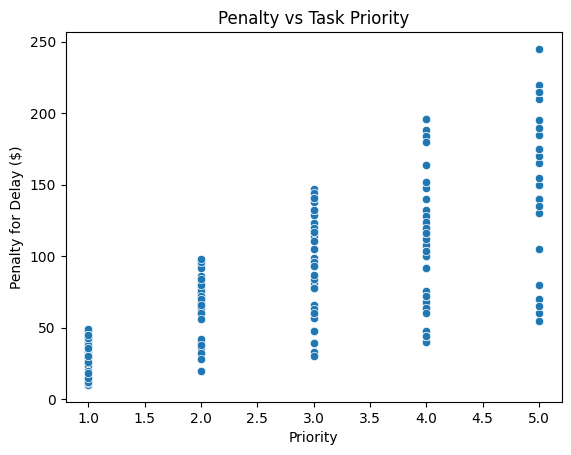

In [5]:
plot = sns.scatterplot(
    data=test,
    x='Priority',
    y='Penalty for Delay ($)'
)
t = plt.title('Penalty vs Task Priority')
plt.show()

This graph shows each Priority level are in set ranges of cost.

In [6]:
test.groupby('Priority')['Penalty for Delay ($)'].describe()

,count,mean,std,min,25%,50%,75%,max
Priority,,,,,,,,
1,51.0,30.921569,11.629004,10.0,19.50,33.0,42.00,49.0
2,36.0,64.888889,20.951342,20.0,59.00,68.0,78.50,98.0
3,42.0,94.714286,35.706996,30.0,63.75,96.0,123.00,147.0
4,43.0,110.976744,47.610267,40.0,70.00,108.0,150.00,196.0
5,28.0,150.000000,55.226805,55.0,123.75,152.5,191.25,245.0


I looked for the min and max for each Priority to create a formula that randomly picks a number between those ranges and apply the formula to the combined_dataset to recreate the Penalty Cost column.

In [7]:
penalty_ranges = {
    1: (10, 50),
    2: (20, 100),
    3: (30, 150),
    4: (40, 200),
    5: (50, 250)
}

def calculate_penalty(priority):
    low, high = penalty_ranges[priority]
    return np.random.randint(low, high)

train['Penalty Cost'] = train['Task Priority'].apply(calculate_penalty)

train.head()

,Technician ID,Task ID,Expertise Match,Task Priority,Task Duration,Distance to Task (km),Task Completed,Penalty Cost
0,T005,J001,0,2,3,1,1,23
1,T006,J002,1,1,2,17,0,26
2,T005,J003,0,2,3,19,1,71
3,T009,J004,1,3,3,15,1,116
4,T003,J005,1,3,2,14,1,125


Of the incomplete tasks, I wanted to see the distribution of the penalty amount by Expertise Match.

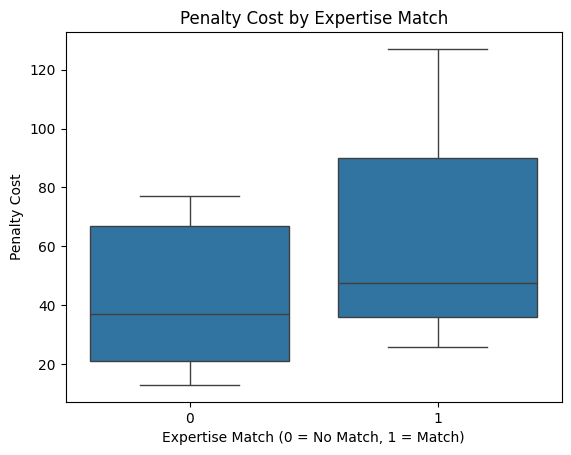

In [8]:
incomplete_tasks = train[train['Task Completed'] == 0]


plot = sns.boxplot(
    data=incomplete_tasks,
    x='Expertise Match',
    y='Penalty Cost'
)
t = plt.title('Penalty Cost by Expertise Match')
x = plt.xlabel('Expertise Match (0 = No Match, 1 = Match)')
y = plt.ylabel('Penalty Cost')
plt.show()

The graph shows that higher penalty costs are associated with tasks matched by expertise, which reflects the system’s practice of assigning high-priority tasks to technicians with matching expertise to reduce operational risk. Because penalty cost is directly driven by task priority, expertise-matched tasks naturally exhibit higher averages and wider spreads in penalty costs.

This indicates that penalty cost and expertise match capture different success dimensions. Expertise Match measures the quality of task assignment, while Penalty Cost measures operational efficiency in task execution.

While some correlation may exist, the two metrics are not directly dependent. A more meaningful analysis would be to compare penalty costs and completion rates within the same priority levels to isolate the impact of expertise matching.

### Expertise Match Rate by Priority and Penalty Cost Distribution by Task Priority & Expertise Match

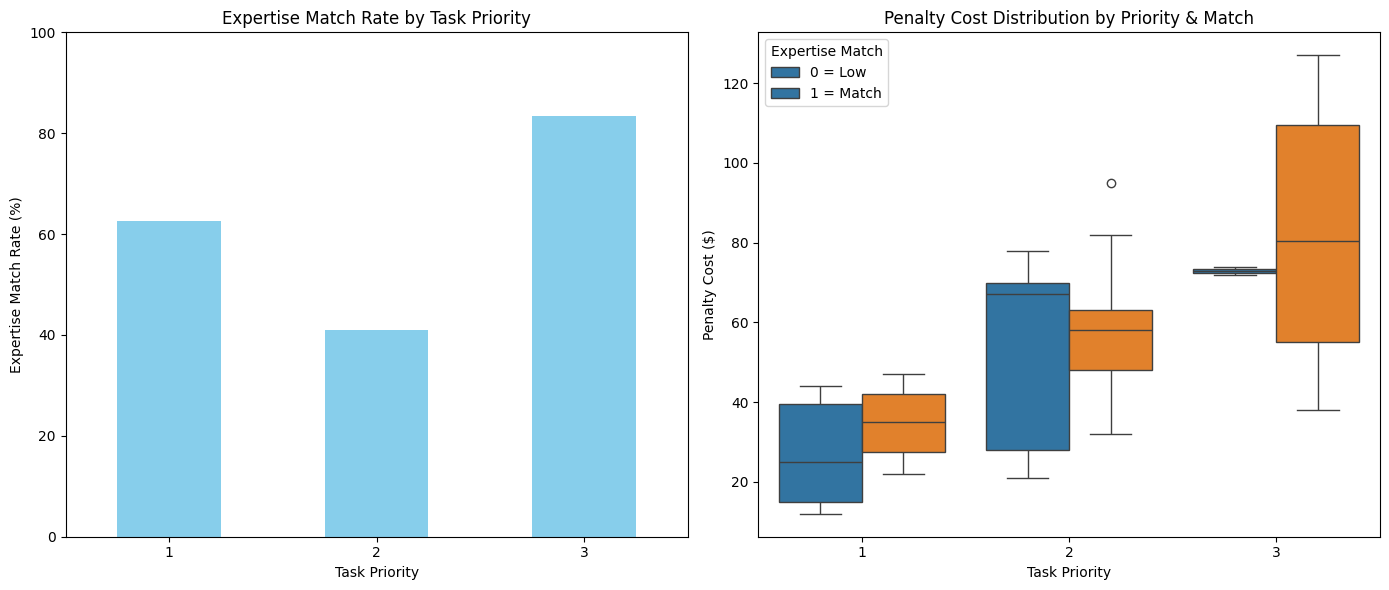

In [9]:
match_rate_by_priority = (
    train
    .groupby('Task Priority')['Expertise Match']
    .mean() * 100 
)

figure = plt.figure(figsize=(14, 6))

# ---------- Panel A: Expertise Match Rate ----------
subplot = plt.subplot(1, 2, 1)
plot = match_rate_by_priority.plot(kind='bar', color='skyblue')
t = plt.title('Expertise Match Rate by Task Priority')
x = plt.xlabel('Task Priority')
y = plt.ylabel('Expertise Match Rate (%)')
ylim = plt.ylim(0, 100)
xticks = plt.xticks(rotation=0)

# ---------- Panel B: Penalty Cost Distribution ----------
subplot = plt.subplot(1, 2, 2)
plot = sns.boxplot(
    data=train,
    x='Task Priority',
    y='Penalty Cost',
    hue='Expertise Match'
)
t = plt.title('Penalty Cost Distribution by Priority & Match')
x = plt.xlabel('Task Priority')
y = plt.ylabel('Penalty Cost ($)')
l = plt.legend(title='Expertise Match', labels=['0 = Low', '1 = Match'])

plt.tight_layout()
plt.show()

Priority 1 tasks are likely more routine, allowing unmatched technicians to handle them effectively, though expertise matching still provides a slight advantage. In contrast, Priority 2–3 tasks are more complex, so the company tends to assign them to matched technicians by default.

For lower-priority tasks (Priority 1), expertise match appears to lower penalty costs, indicating a positive impact on operational efficiency. However, for mid-priority tasks (Priority 2–3), penalty costs are higher for matched technicians, likely because these tasks are inherently more complex or costly, not because of technician mismatch.

This pattern reinforces that expertise match and penalty cost measure different dimensions of success—expertise match reflects the quality of task assignment, while penalty cost reflects task risk and execution efficiency.

### Customer Rating vs Task Completed

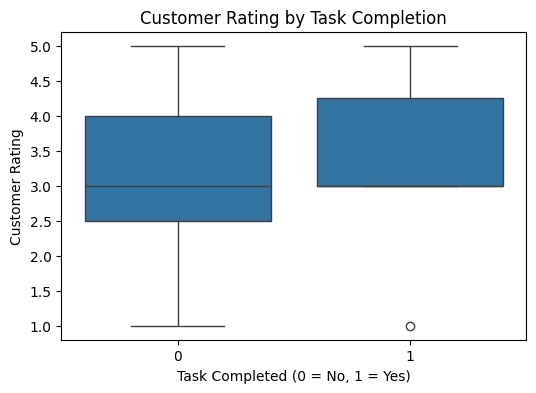

In [10]:
merged_df = pd.merge(
    train[['Task Priority', 'Distance to Task (km)', 'Task Completed']],
    test[['Priority', 'Distance to Task (km)',  'Customer Rating']],
    left_on=['Task Priority', 'Distance to Task (km)'],
    right_on=['Priority', 'Distance to Task (km)'],
    how='inner'
)

figure = plt.figure(figsize=(6,4))
plot = sns.boxplot(
    data=merged_df,
    x='Task Completed',
    y='Customer Rating'
)
t = plt.title('Customer Rating by Task Completion')
x = plt.xlabel('Task Completed (0 = No, 1 = Yes)')
y = plt.ylabel('Customer Rating')
plt.show()

The spread of customer ratings is higher for completed tasks compared to those not completed, indicating that customers have more positive experiences when tasks are successfully completed. This suggests that the company should prioritize improving task completion rates, as it directly contributes to higher customer satisfaction.

### Number of Tasks in Customer Rating

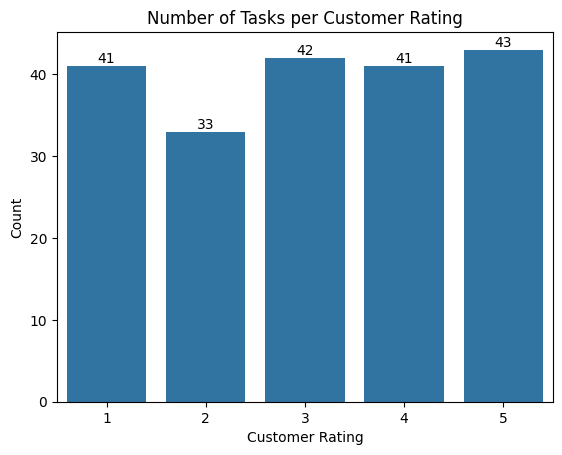

In [11]:
ax = sns.countplot(data=test, x='Customer Rating')
t = plt.title('Number of Tasks per Customer Rating')
x = plt.xlabel('Customer Rating')
y = plt.ylabel('Count')

for p in ax.patches:
    an = ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')
    
plt.show()

The distribution of Customer Ratings is relatively even across all levels, indicating that there is significant room for improvement in customer satisfaction. Specifically, the company has the opportunity to convert lower ratings (1s and 2s) into mid-to-high ratings (3 and above) through improved task execution and service quality.